# Selection observed SDSS spectra for validation
I will select SDSS spectra that are within the support of the training data. We'll do this by training a normalizing flow for the training data and then using a logprob threshold to pick SDSS galaxies

In [1]:
import os
import numpy as np 

In [2]:
import torch
from torch import optim
from nflows import transforms, distributions, flows

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
seed = 0 
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

torch.manual_seed(seed)
if cuda: torch.cuda.manual_seed(seed)

# import observations

In [5]:
dat_dir = '/scratch/network/chhahn/sedflow/'
obs_enc_spec = np.load(os.path.join(dat_dir, 'sedflow_p.obs.v0.1.encoded.npy'))
obs_enc_ivar = np.load(os.path.join(dat_dir, 'sedflow_p.obs.v0.1.ivar.encoded.npy'))
obs_zred = np.load(os.path.join(dat_dir, 'sedflow_p.obs.v0.1.zred.npy'))

In [6]:
zlim = (obs_zred < 0.06)

In [7]:
obs_data = np.concatenate([obs_enc_spec, obs_enc_ivar, obs_zred[:,None]], axis=1)[zlim]

# import train/test data

In [8]:
test_theta_sps = np.load(os.path.join(dat_dir, 'sedflow_p.test.v0.1.theta_sps.npy'))
test_theta_unt = np.load(os.path.join(dat_dir, 'sedflow_p.test.v0.1.theta_unt.npy'))
test_enc_spec = np.load(os.path.join(dat_dir, 'sedflow_p.test.v0.1.encoded.npy'))
test_enc_ivar = np.load(os.path.join(dat_dir, 'sedflow_p.test.v0.1.ivar.encoded.npy'))
test_zred = np.load(os.path.join(dat_dir, 'sedflow_p.test.v0.1.zred.npy'))

In [9]:
test_data = np.concatenate([test_enc_spec, test_enc_ivar, test_zred[:,None]], axis=1)

In [10]:
aspec_clean = test_data[:,0] < 1e3
test_data = test_data[aspec_clean]

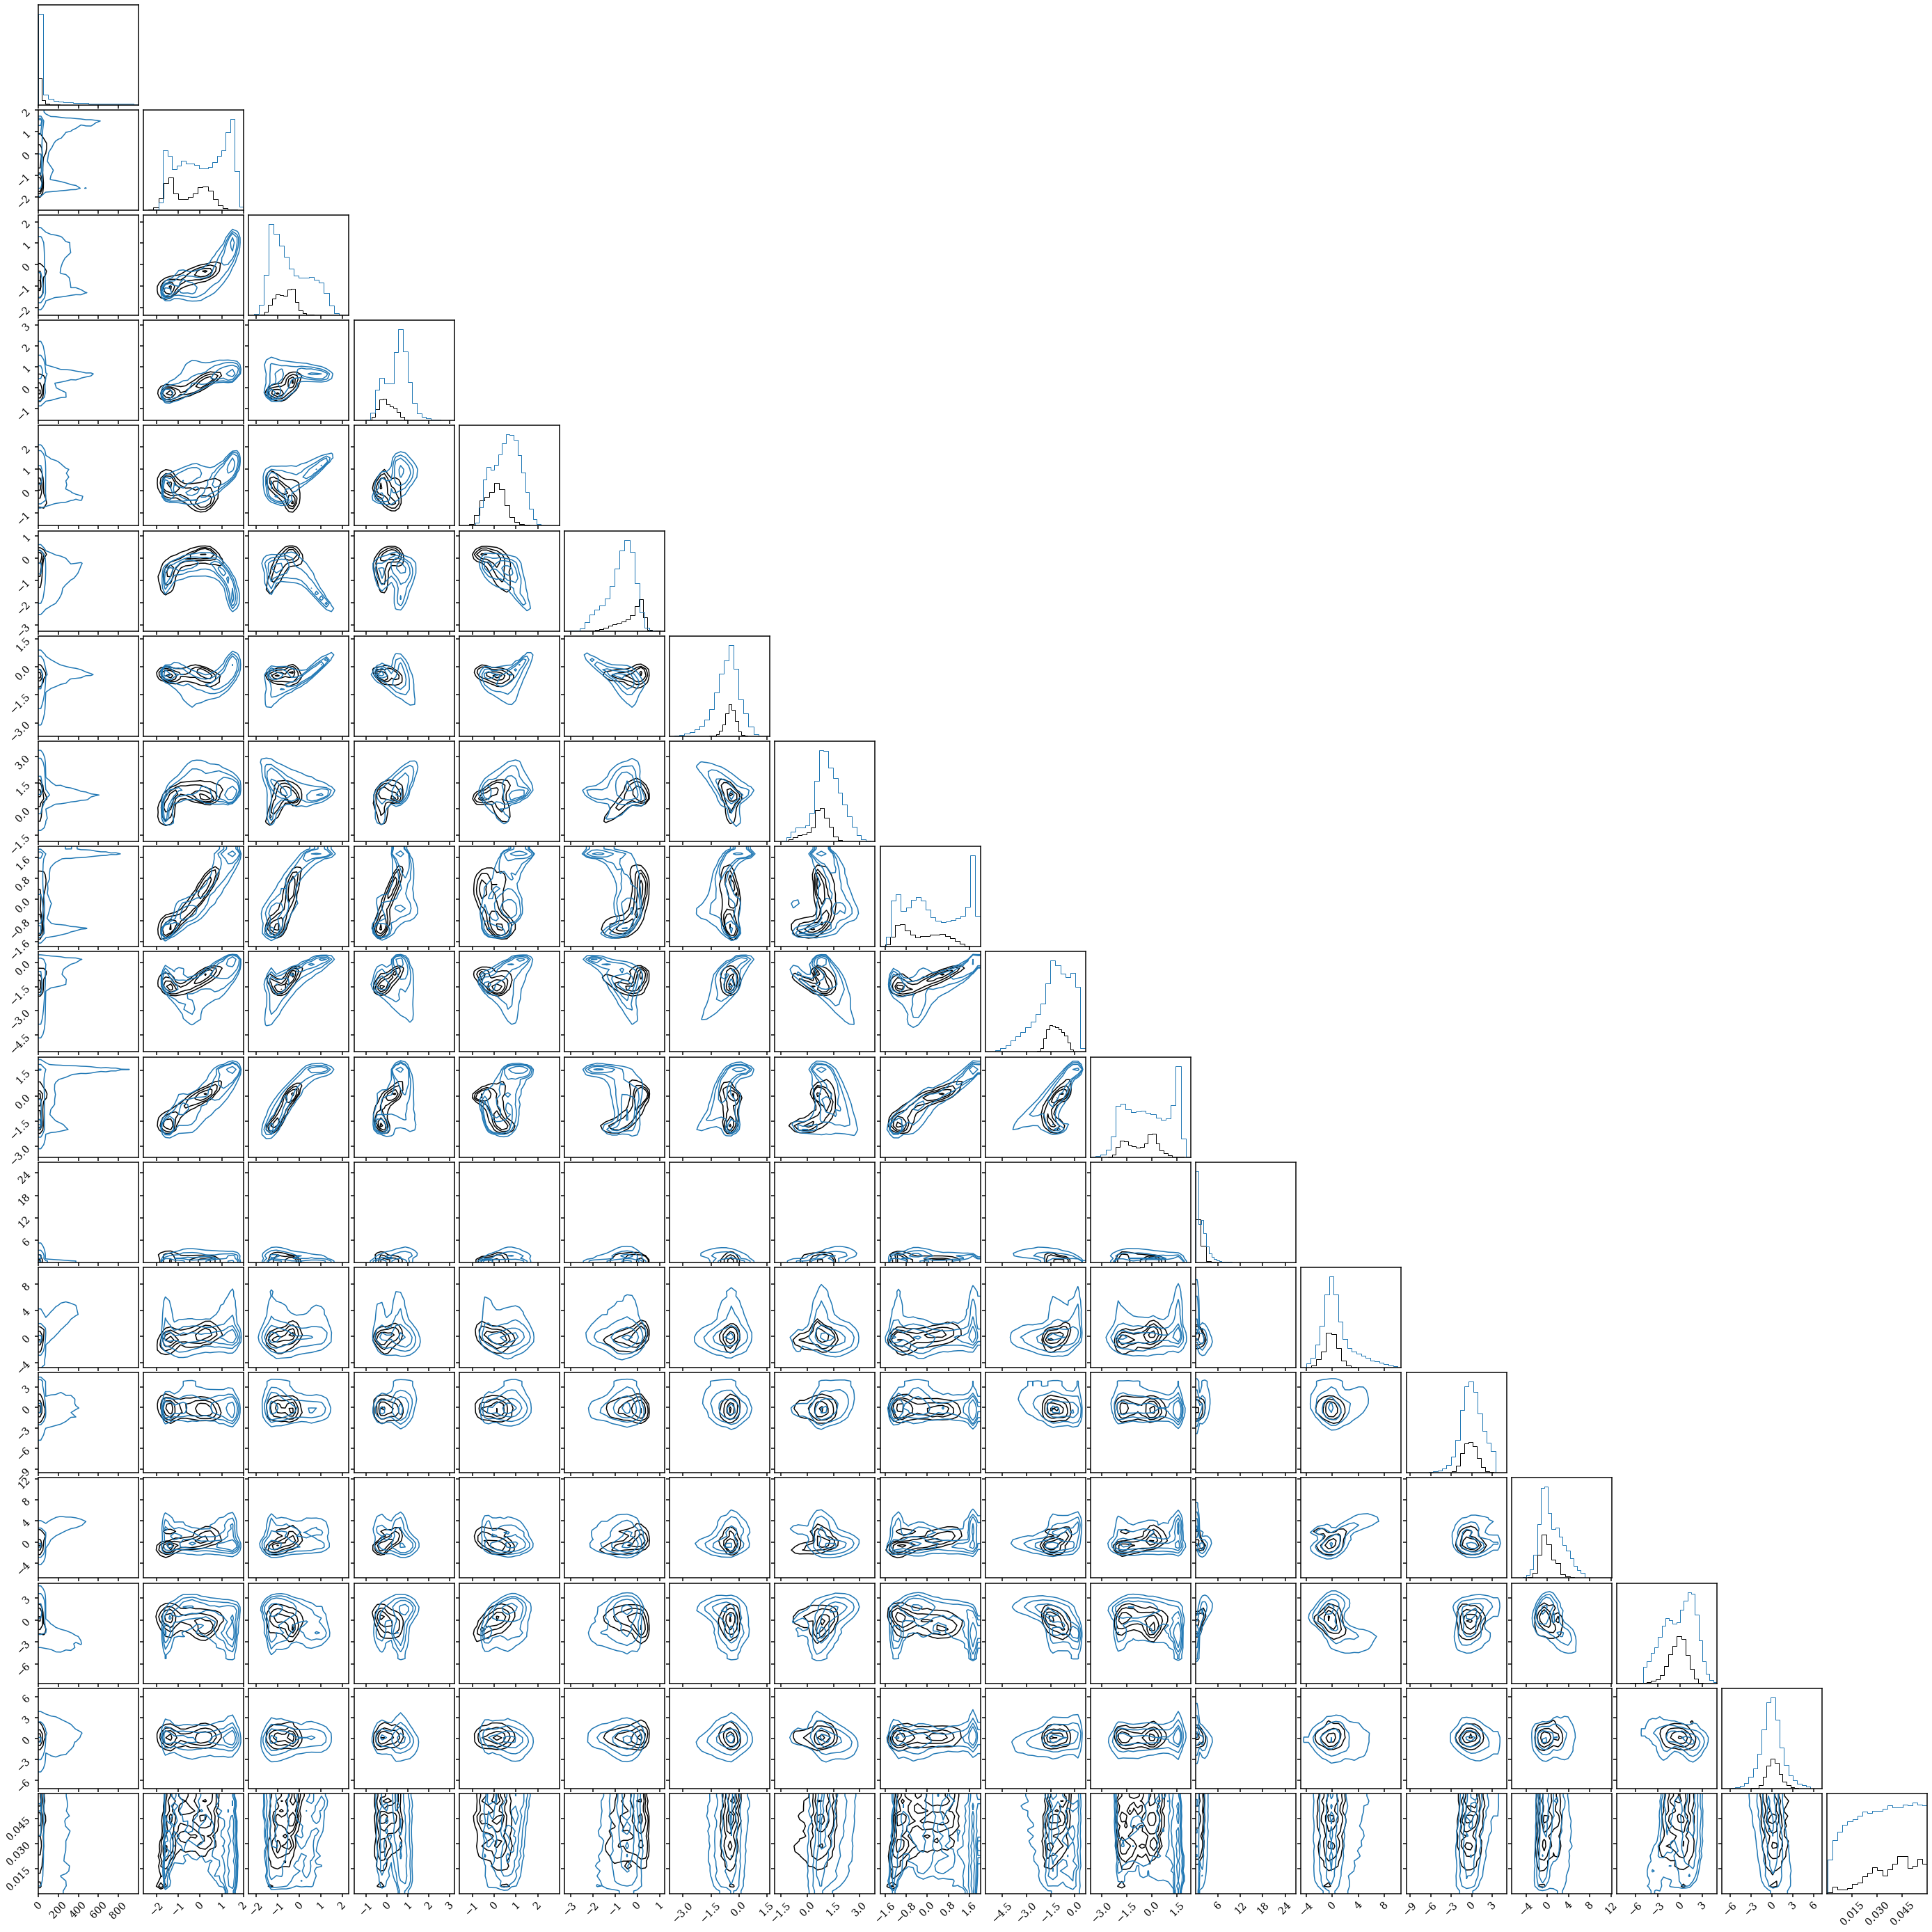

In [11]:
fig = DFM.corner(obs_data, plot_datapoints=False, plot_density=False)
_ = DFM.corner(test_data, plot_datapoints=False, plot_density=False, color='C0', fig=fig)

# train NDE on train/test data

In [12]:
ndim = obs_data.shape[1]
Ntrain = int(0.9 * test_data.shape[0])
train_loader = torch.utils.data.DataLoader(
        torch.tensor(test_data[:Ntrain].astype(np.float32)).to(device), 
        batch_size=512, shuffle=True)
valid_loader = torch.utils.data.DataLoader(
        torch.tensor(test_data[Ntrain:].astype(np.float32)).to(device), 
        batch_size=512, shuffle=False)

In [14]:
all_flows, all_archs, all_valid_losses = [], [], []
for i in range(5): 
    nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(64), np.log(256)))))
    nblocks = int(np.random.uniform(3, 7))
    all_archs.append('%ix%i' % (nhidden, nblocks))

    blocks = []
    for iblock in range(nblocks): 
        blocks += [transforms.MaskedAffineAutoregressiveTransform(features=ndim, hidden_features=nhidden),
                transforms.RandomPermutation(features=ndim)]
    transform = transforms.CompositeTransform(blocks)

    base_distribution = distributions.StandardNormal(shape=[ndim])
    flow = flows.Flow(transform=transform, distribution=base_distribution)
    flow.to(device)

    num_iter = 1000
    patience = 20

    optimizer = optim.Adam(flow.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 1e-3, total_steps=num_iter)

    best_epoch, best_valid_loss, valid_losses = 0, np.inf, []
    for epoch in range(num_iter):
        train_loss = 0.
        for batch in train_loader: 
            optimizer.zero_grad()
            loss = -flow.log_prob(batch).mean()
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        train_loss = train_loss/float(len(train_loader))

        with torch.no_grad():
            valid_loss = 0.
            for batch in valid_loader: 
                loss = -flow.log_prob(batch).mean()
                valid_loss += loss.item()
            valid_loss = valid_loss/len(valid_loader)
            valid_losses.append(valid_loss)

            if epoch % 20 == 0: print('%i \t %.2e \t %.2e' % (epoch, train_loss, valid_loss))
            if valid_loss < best_valid_loss: 
                best_valid_loss = valid_loss
                best_epoch = epoch
            else: 
                if best_epoch < epoch - patience: 
                    print('>>>%i \t %.5e' % (epoch, best_valid_loss))
                    break
            scheduler.step()

    all_flows.append(flow)
    all_valid_losses.append(valid_losses)

0 	 7.25e+05 	 3.89e+03
20 	 3.22e+01 	 3.20e+01
40 	 2.08e+01 	 2.06e+01
60 	 1.51e+01 	 1.50e+01
80 	 1.22e+01 	 1.22e+01
100 	 1.11e+01 	 1.09e+01
120 	 1.00e+01 	 1.02e+01
140 	 1.13e+01 	 1.22e+01
160 	 1.05e+01 	 1.14e+01
180 	 8.63e+00 	 8.78e+00
200 	 8.70e+00 	 9.23e+00
>>>200 	 8.60983e+00
0 	 7.61e+14 	 1.08e+13
80 	 7.85e+05 	 2.11e+05
100 	 5.25e+03 	 5.63e+03
120 	 4.43e+02 	 4.81e+02
140 	 5.89e+01 	 5.95e+01
160 	 4.67e+01 	 4.78e+01
180 	 3.37e+01 	 3.44e+01
200 	 2.23e+03 	 1.44e+03
>>>218 	 3.04854e+01
0 	 nan 	 nan
20 	 nan 	 nan
>>>21 	 inf
0 	 1.72e+05 	 4.00e+02
20 	 2.48e+01 	 2.45e+01
40 	 1.68e+01 	 1.67e+01
60 	 1.32e+01 	 1.33e+01
80 	 1.15e+01 	 1.17e+01
100 	 1.06e+01 	 1.10e+01
120 	 1.00e+01 	 1.01e+01
140 	 1.01e+01 	 1.17e+01
160 	 9.25e+00 	 9.06e+00
180 	 8.52e+00 	 8.70e+00
200 	 7.87e+00 	 9.28e+00
220 	 7.34e+00 	 7.67e+00
240 	 6.85e+00 	 8.14e+00
260 	 6.45e+00 	 7.11e+00
280 	 6.15e+00 	 7.26e+00
300 	 5.83e+00 	 7.05e+00
320 	 5.63e+00 	 6.55e

In [24]:
ibest = 3#np.argmin([np.min(vl) for vl in all_valid_losses])
best_flow = all_flows[ibest]
best_arch = all_archs[ibest]

In [25]:
with torch.no_grad(): 
    nde_samples = best_flow.sample(10000)

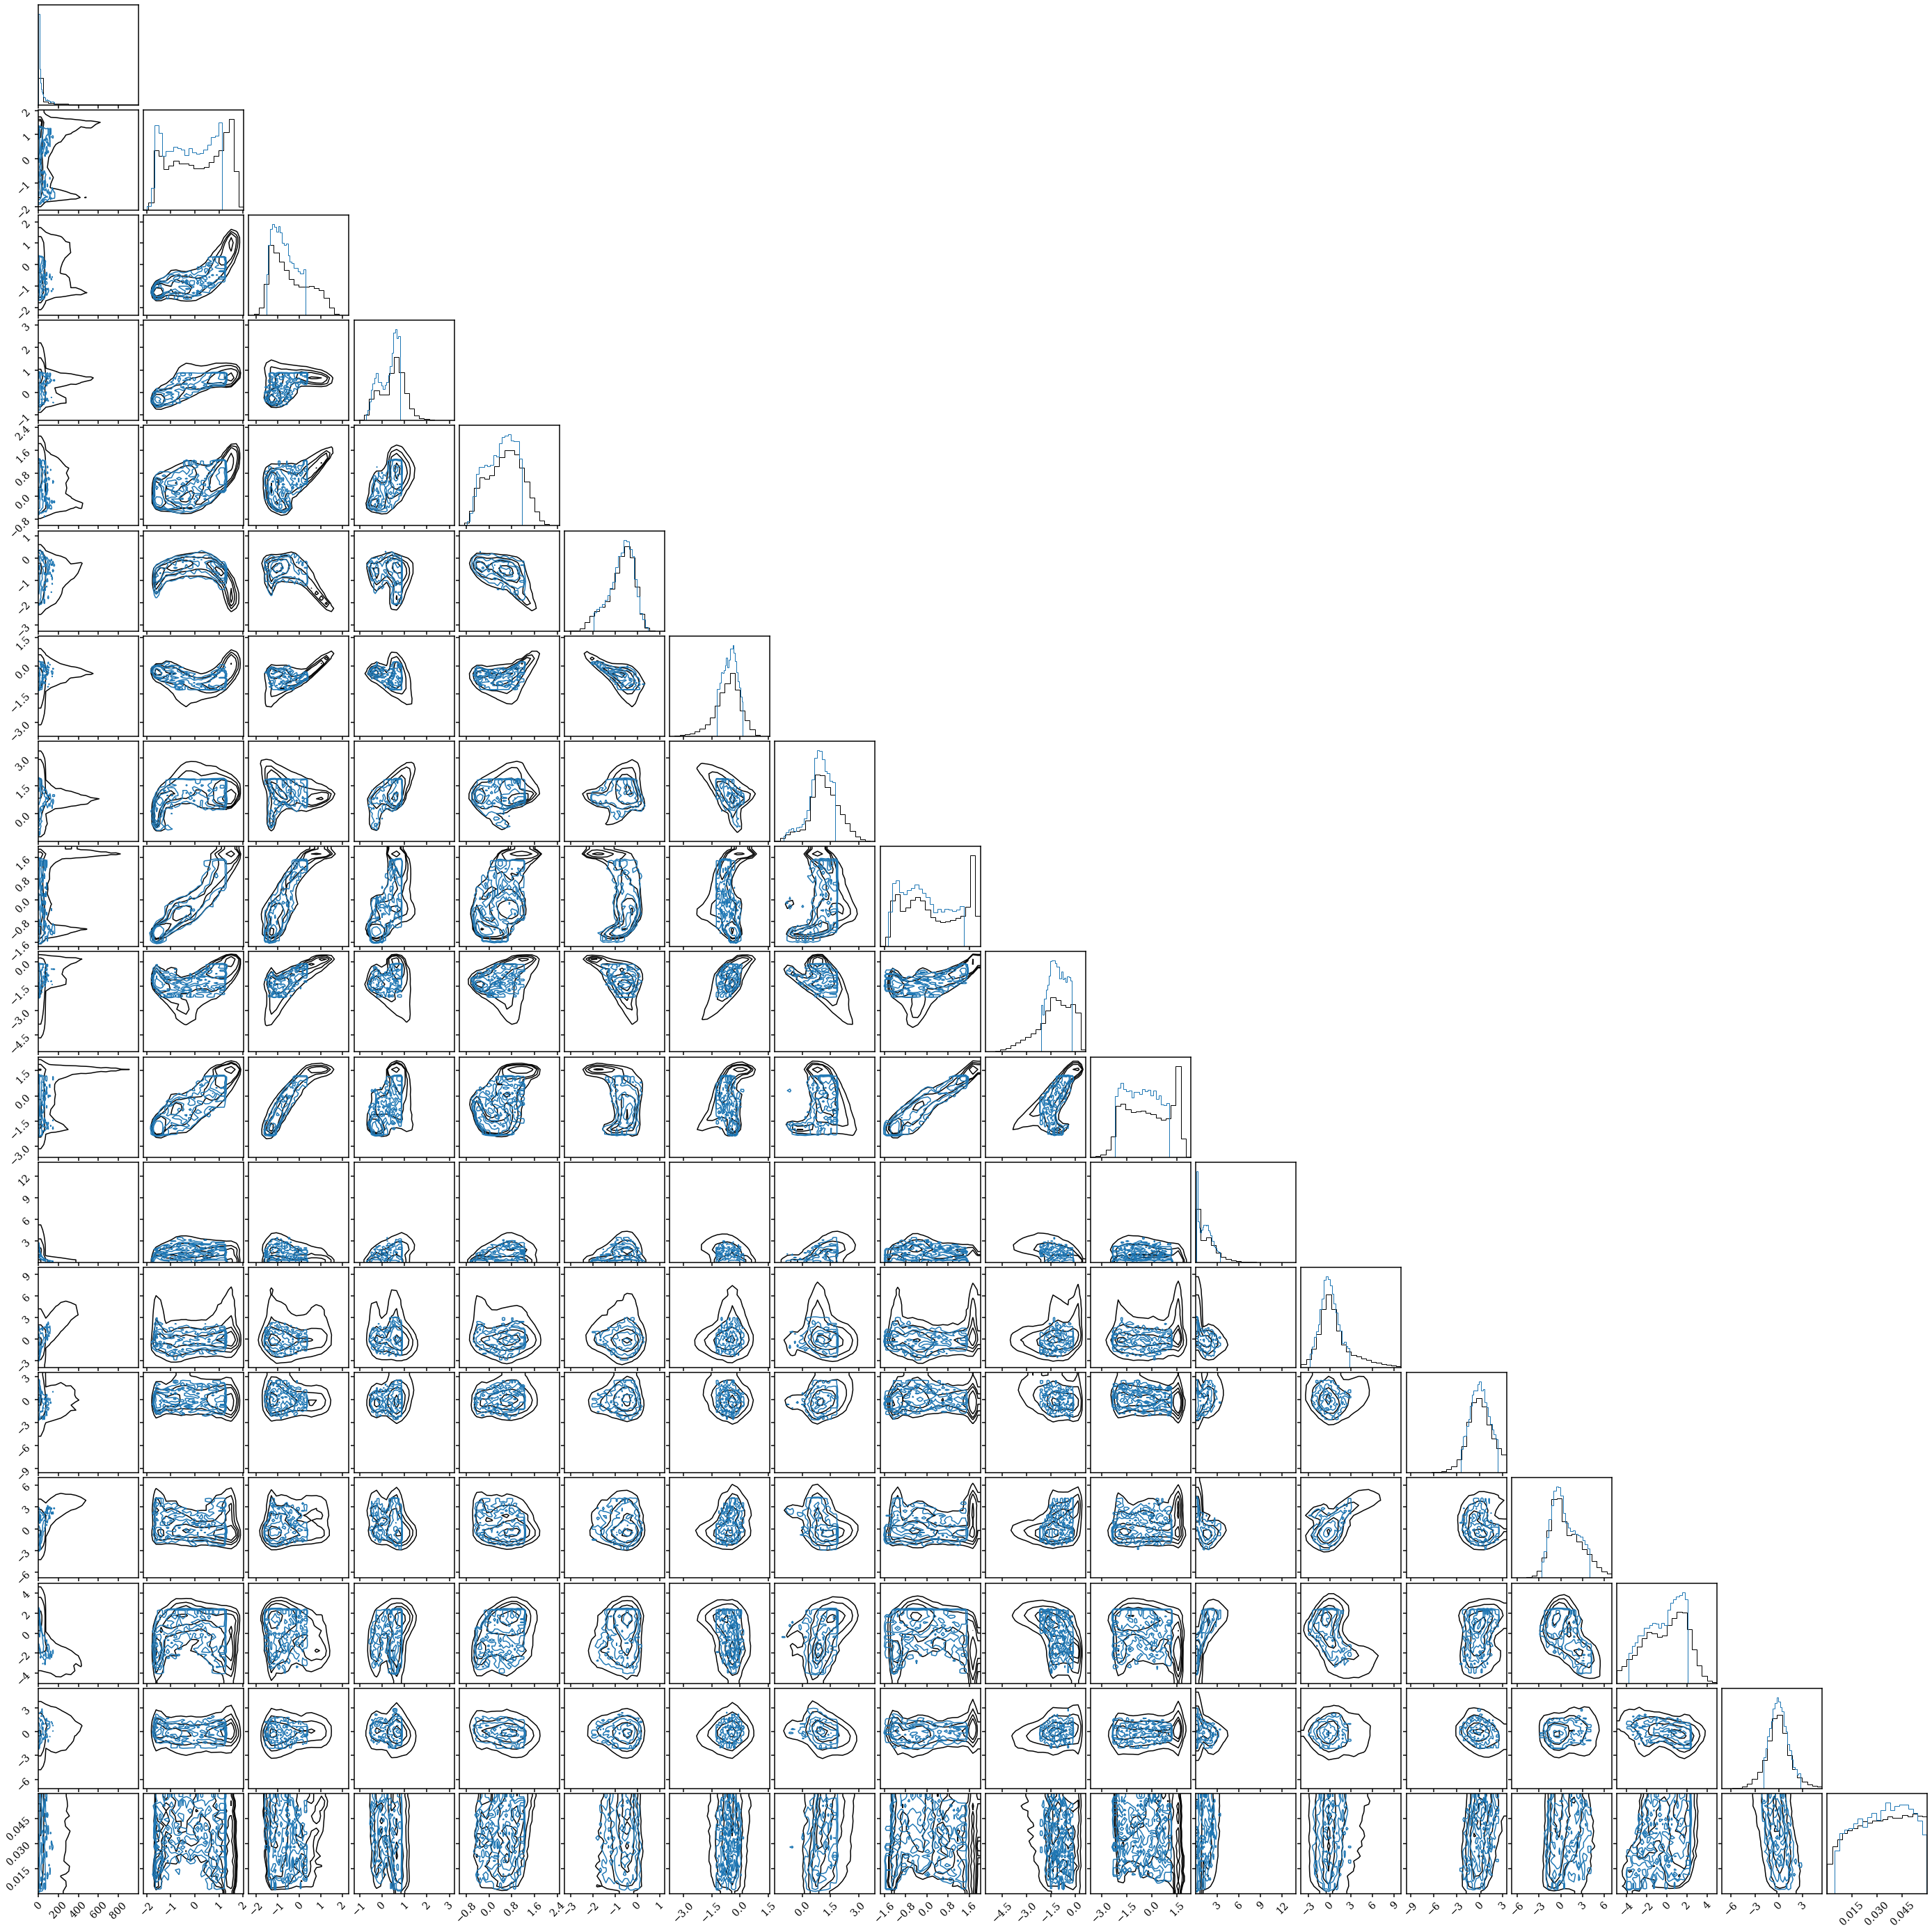

In [26]:
fig = DFM.corner(test_data,
                 hist_kwargs={'density': True},
                 plot_datapoints=False, plot_density=False)
_ = DFM.corner(np.array(nde_samples.detach().cpu()), color='C0', 
               range=[np.nanquantile(obs_col, [0.01, 0.99]) for obs_col in obs_data.T],
               hist_kwargs={'density': True},
               plot_datapoints=False, plot_density=False, fig=fig)

## keep only the observations within train/test data support 

In [27]:
obs_loader = torch.utils.data.DataLoader(
    torch.tensor(obs_data.astype(np.float32)).to(device), 
    batch_size=512, shuffle=False)

with torch.no_grad(): 
    obs_logprob = []
    for batch in obs_loader: 
        logprob = best_flow.log_prob(batch)
        obs_logprob.append(np.array(logprob.detach().cpu()))
obs_logprob = np.concatenate(obs_logprob)

In [31]:
logprob_cut = (obs_logprob > -10)
print(np.sum(logprob_cut))

2230


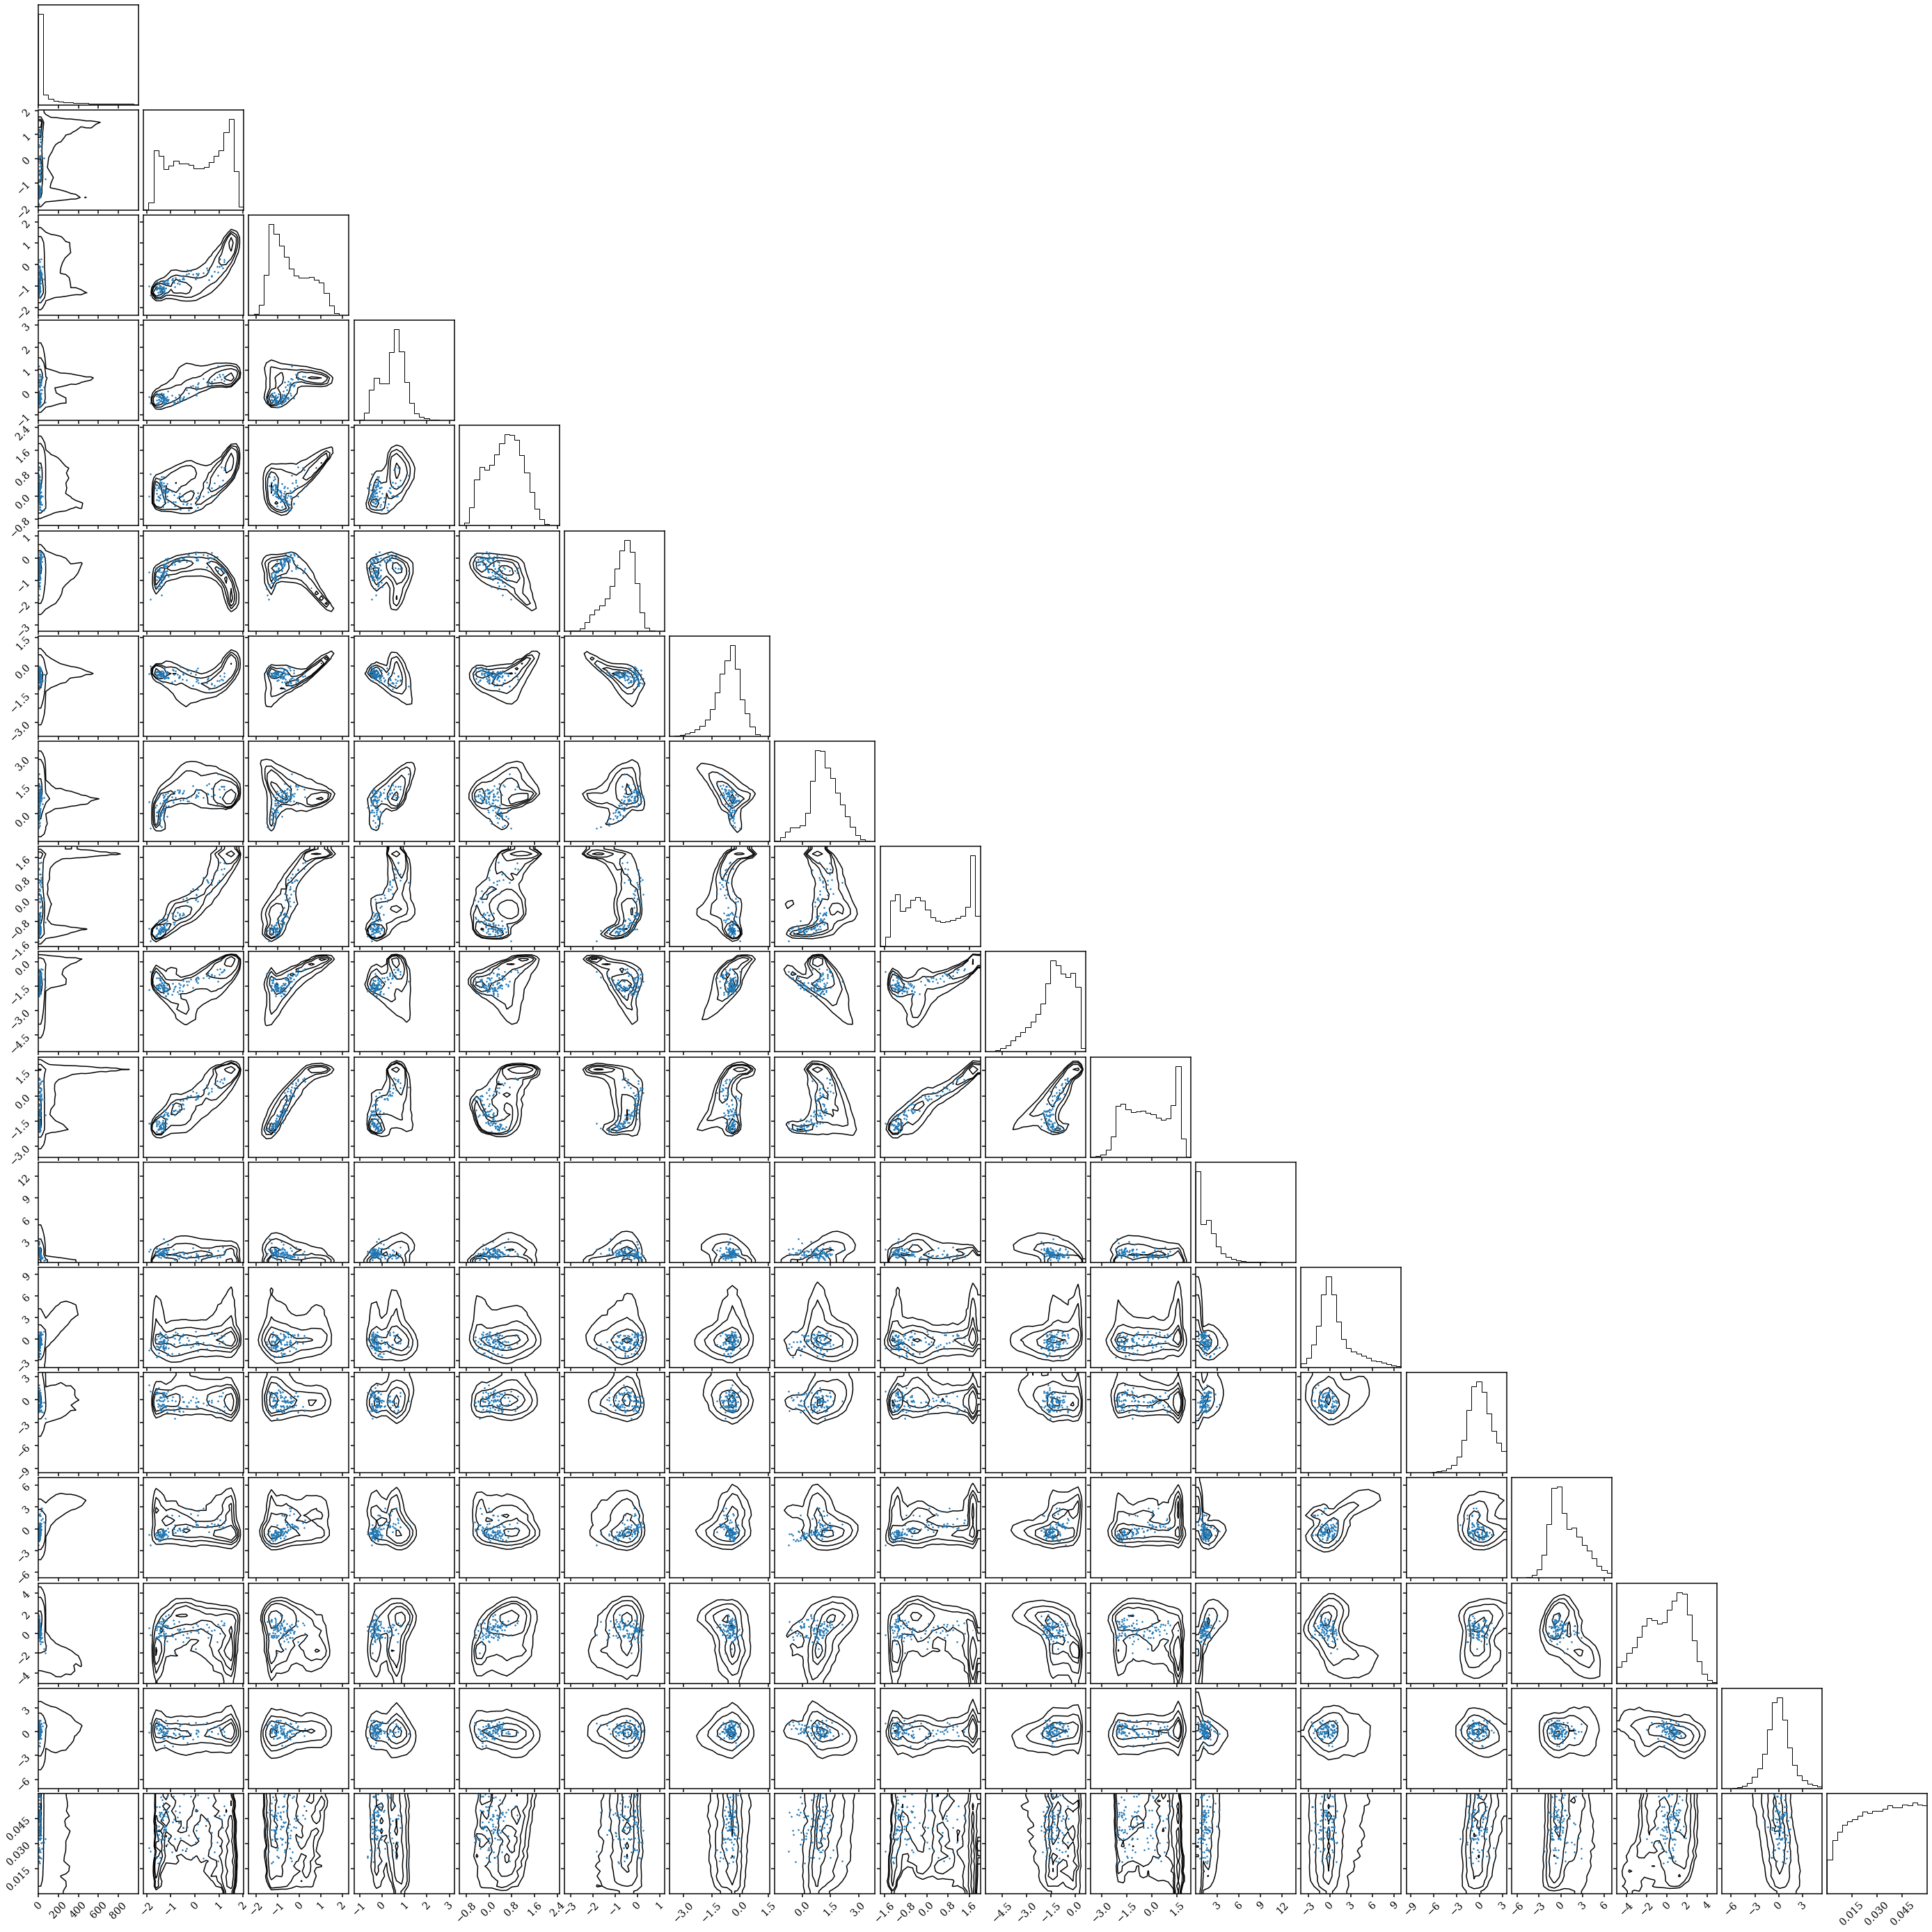

In [52]:
fig = DFM.corner(test_data,
                 hist_kwargs={'density': True},
                 plot_datapoints=False, plot_density=False)
DFM.overplot_points(fig, obs_data[logprob_cut][:100], color='C0', markersize=3)

In [48]:
all_cuts = zlim
all_cuts[np.where(zlim)[0][~logprob_cut]] = False

In [50]:
np.save(os.path.join(dat_dir, 'sedflow_p.obs_intrain.v0.1.encoded.npy'), all_cuts)
np.save(os.path.join(dat_dir, 'sedflow_p.obs_intrain.v0.1.encoded.npy'), obs_enc_spec[all_cuts])
np.save(os.path.join(dat_dir, 'sedflow_p.obs_intrain.v0.1.ivar.encoded.npy'), obs_enc_ivar[all_cuts])
np.save(os.path.join(dat_dir, 'sedflow_p.obs_intrain.v0.1.zred.npy'), obs_zred[all_cuts])